In [1]:
import json

# Load the dataset
dataset_path = 'data/dev.jsonl'
data = []

with open(dataset_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Display the structure of the first item
print(json.dumps(data[0], indent=2))


{
  "label": "partially_supported",
  "claim": "Arnold is currently the publisher and editorial director of Media Play News, one of five Hollywood trades and the only one dedicated to the home entertainment sector.",
  "evidence": [
    "Media Play News",
    "Media Play News is the voice of the home entertainment industry.",
    "We reach major studios, independent suppliers, technology companies such as Microsoft and Roku and a growing number of distributors of digital content.",
    "Thomas K. Arnold, Publisher and Editorial Director, Media Play News:",
    "For more than 12 years he was the Publisher and Editorial Director of Home Media Magazine, the home entertainment industry's weekly trade publication.",
    "He joined Video Store Magazine, Home Media's predecessor, in 1991.",
    "She spearheaded the publication's reviews section, as well as aggressive coverage of the home video sales market.",
    "She also helped launch the magazine's Web site in 1996.",
    "In her position 

In [2]:
len(data)

1043

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Initialize tokenizer and model
model_name = "roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
nli_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)


/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/jonathanhu/anaconda3/envs/Retri

In [19]:
# Function to predict claim entailment using only oracle_idx evidence sentences
def predict_claim_entailment_with_corrected_oracle(claim, evidence_sentences, meta):
    # Retrieve chunk_idx and oracle_idx from meta information
    chunk_indices = meta['chunk_idx']
    oracle_indices = meta['oracle_idx']
    
    # Map oracle_idx to the actual positions in evidence_sentences using chunk_idx
    actual_oracle_sentences = [evidence_sentences[chunk_indices.index(oracle_idx)] for oracle_idx in oracle_indices if oracle_idx in chunk_indices]
    
    # Concatenate the oracle evidence sentences
    oracle_evidence_text = " ".join(actual_oracle_sentences)
    
    # Predict the entailment using the NLI model
    predictions = nli_pipeline(f"{claim} [SEP] {oracle_evidence_text}")

    return predictions

In [20]:
# Example 
test_claim = data[0]['claim']
test_evidence = data[0]['evidence']
meta_info = data[0]['meta']

# Predict entailment using corrected oracle evidence
corrected_prediction = predict_claim_entailment_with_corrected_oracle(test_claim, test_evidence, meta_info)
print(corrected_prediction)

[[{'label': 'CONTRADICTION', 'score': 0.020967280492186546}, {'label': 'NEUTRAL', 'score': 0.38942232728004456}, {'label': 'ENTAILMENT', 'score': 0.5896103978157043}]]


Processing items: 100%|██████████| 1043/1043 [02:31<00:00,  6.87it/s]


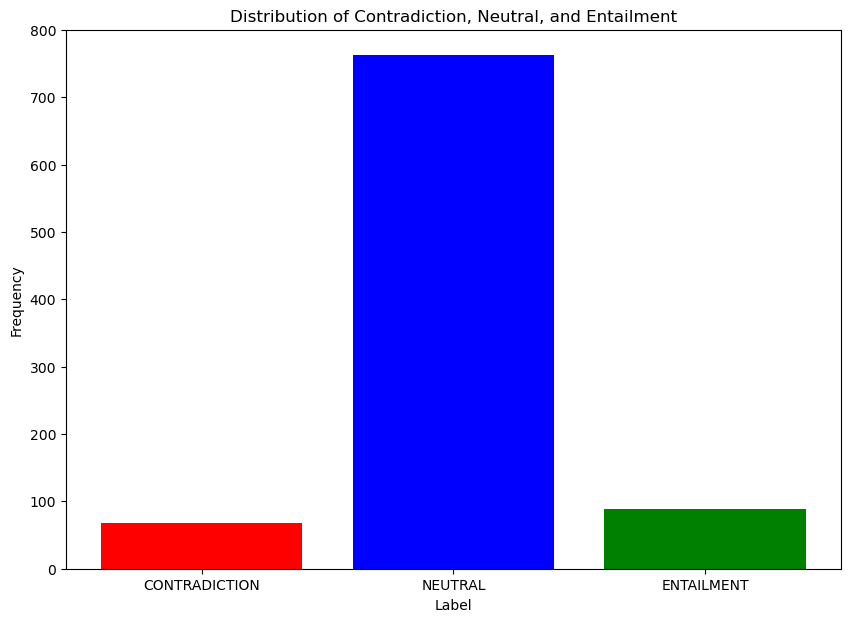

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize a dictionary to hold the count of each label
label_counts = {"CONTRADICTION": 0, "NEUTRAL": 0, "ENTAILMENT": 0}

num_false = 0 # number of times prediction is wrong
# Define label mapping based on your dataset's specifics TODO: is this how we want to represent it
label_mapping = {
    "not_supported": "CONTRADICTION",
    "partially_supported": "NEUTRAL",
    "supported": "ENTAILMENT",
}

# Process each item in the dataset
for item in tqdm(data, desc="Processing items"):
    if 'oracle_idx' not in item['meta']:
        continue
    corrected_prediction = predict_claim_entailment_with_corrected_oracle(item['claim'], item['evidence'], item['meta'])
    corrected_prediction = corrected_prediction[0]
    # Increment the count of the predicted label. We select the highest scoring label for simplicity.
    highest_score_label = sorted(corrected_prediction, key=lambda x: x['score'], reverse=True)[0]['label']
    if highest_score_label != label_mapping[item['label']]:
        num_false += 1
    label_counts[highest_score_label] += 1

# Plotting the distribution
labels = label_counts.keys()
counts = label_counts.values()

plt.figure(figsize=(10, 7))
plt.bar(labels, counts, color=['red', 'blue', 'green'])
plt.title('Distribution of Contradiction, Neutral, and Entailment')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [23]:
print(f"Accuracy is {1 - num_false / len(data)}")

Accuracy is 0.6078619367209972
